In [1]:
from qdtuner import QuantumDotFET, qc, FET_DataAnalyzer
# !python -m qcodes.monitor.monitor

In [ ]:
QD_FET_Tuner = QuantumDotFET(
    device_config='../device_config.yml',
    setup_config='../setup_config.yaml',
    tuner_config='../fet_tuner_config.yaml',
    station_config='../station_config.yaml',
    save_dir='C:\\Users\\coher\\Desktop\\Andrija'
)

In [ ]:
# monitor = qc.Monitor(
#     QD_FET_Tuner.drain_volt, 
#     QD_FET_Tuner.voltage_source.S, 
#     QD_FET_Tuner.voltage_source.STL,
#     QD_FET_Tuner.voltage_source.LB,
#     QD_FET_Tuner.voltage_source.P,
#     QD_FET_Tuner.voltage_source.RB,
#     QD_FET_Tuner.voltage_source.STR
#     )
# monitor.show()

In [ ]:
QD_FET_Tuner.bias_ohmic(
    ohmic='S', 
    V=0.005
) 

In [ ]:
QD_FET_Tuner.turn_on(
    minV=0, 
    maxV=None,
    dV=0.05
)

In [ ]:
QD_FET_Tuner.device_info['properties']['turn_on'] = {'measured_current': 1.4752252e-09, 'measured_resistance': 33893.13,
      'saturation_voltage': -2.85, 'voltage': -1.891}
QD_FET_Tuner.deviceTurnsOn=True

In [ ]:
QD_FET_Tuner.pinch_off(
    minV=None, 
    maxV=None, 
    dV=0.05,
    voltage_configuration={}
)

In [ ]:
df, current_axes = QD_FET_Tuner.sweep_barriers(
    B1='LB', 
    B2='RB', 
    B1_bounds=(-2,-1),
    B2_bounds=(-1.25,-1),
    dV=0.05,
    voltage_configuration={},
    extract_bias_point=True
)

In [ ]:
bp, voltage_window = QD_FET_Tuner.DataAnalyzer.extract_bias_point(
    df,
    plot_process=False,
    axes=current_axes
)
print(bp, voltage_window)

In [ ]:
QD_FET_Tuner.coulomb_blockade(
    P='P', 
    P_bounds=(0,0.75), 
    dV=0.05,
    voltage_configuration={'S': 0.005, 'LB': -0.55, 'RB': -0.7}, 
)

In [ ]:
QD_FET_Tuner.coulomb_diamonds(
    ohmic='S', 
    gate='P', 
    ohmic_bounds=(-0.015, 0.015),
    gate_bounds=(0,0.75),
    dV_gate=0.03, 
    dV_ohmic=0.01,
    voltage_configuration={'LB': -0.55, 'RB': -0.7},
)

In [ ]:
QD_FET_Tuner.current_trace(
    f_sampling=1000,
    t_capture=60, 
    plot_psd=True
)

In [ ]:
QD_FET_Tuner.ground_device()

# DATABASE VIEWER

In [ ]:
db_file = "/Users/andrijapaurevic/Desktop/experiments_N44_D54_2024-05-08.db"
# import IPython.lib.backgroundjobs as bg
# from plottr.apps import inspectr

# jobs = bg.BackgroundJobManager()
# jobs.new(inspectr.main, db_file)

      sim900_volt_LB  sim900_volt_RB  agilent_volt
0              0.713           0.755     -0.011932
1              0.713           0.753     -0.012109
2              0.713           0.751     -0.012049
3              0.713           0.749     -0.011928
4              0.713           0.747     -0.011776
...              ...             ...           ...
8276           0.533           0.583      0.000072
8277           0.533           0.581      0.000070
8278           0.533           0.579      0.000077
8279           0.533           0.577      0.000083
8280           0.533           0.575      0.000087

[8281 rows x 3 columns]


/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/src/inference.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours = np.subtract(contours, 1)


Suggested voltage window: {'RB': (0.615, 0.747), 'LB': (0.533, 0.631)}
Suggested bias point: {'RB': 0.636, 'LB': 0.584}
{'RB': 0.636, 'LB': 0.584} {'RB': (0.615, 0.747), 'LB': (0.533, 0.631)}


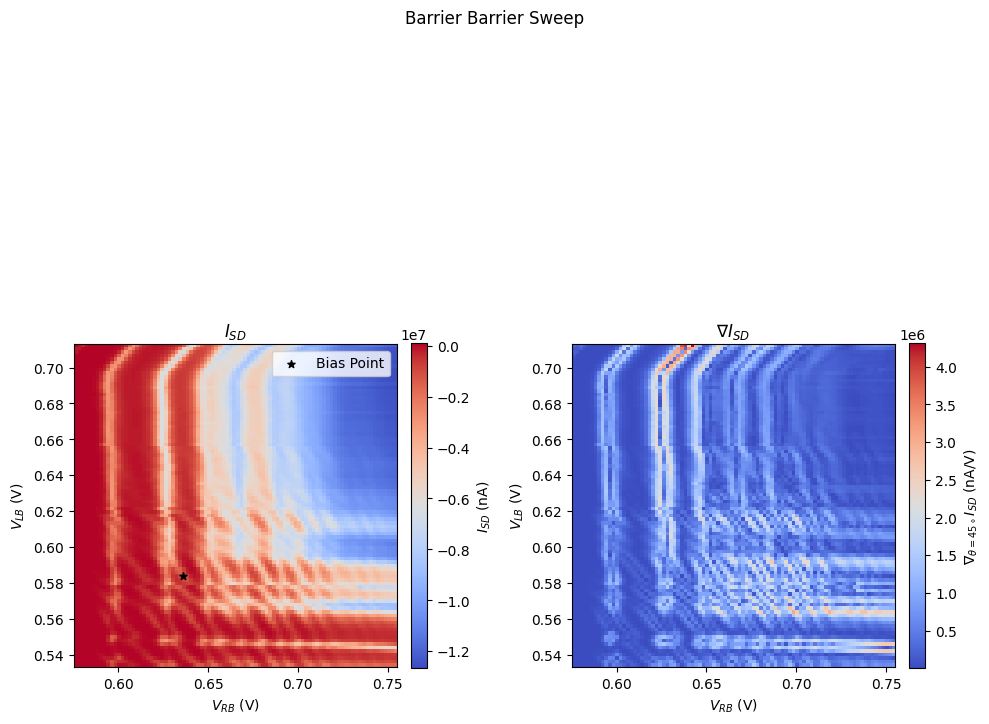

In [3]:
db_file = "/Users/andrijapaurevic/Desktop/experiments_N44_D54_2024-05-08.db"


import qcodes as qc


import sys, os
import matplotlib.pyplot as plt 
qc.dataset.initialise_or_create_database_at(db_file)
tutorial_exp = qc.dataset.load_or_create_experiment(
    experiment_name="Initialization",
    sample_name="N44_D54"
)

dataset = qc.dataset.load_by_run_spec(experiment_name='Initialization', captured_run_id=5)
# qc.dataset.plot_dataset(dataset)
df = dataset.to_pandas_dataframe().reset_index()

In [ ]:
import skimage
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data
import matplotlib.cm as cm


range_RB = (0.615,0.747)
range_LB = (0.533,0.631)
filtered_df = df[
    (df['sim900_volt_RB'] >= range_RB[0]) & (df['sim900_volt_RB'] <= range_RB[1]) &
    (df['sim900_volt_LB'] >= range_LB[0]) & (df['sim900_volt_LB'] <= range_LB[1])
]

cropped_img, Xdata, Ydata = convert_data_to_image(filtered_df)
cropped_img = cropped_img[:,:,0]
edges = canny(cropped_img,sigma=0.5, low_threshold=0.1*np.iinfo(np.uint8).max, high_threshold=0.3 * np.iinfo(np.uint8).max)
lines = probabilistic_hough_line(edges, threshold=0, line_length=3,
                                 line_gap=0)
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(cropped_img, cmap=cm.gray, origin='lower', extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()],)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray, origin='lower',  extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()],)
ax[1].set_title('Masked Canny edges')

potential_points = {}
angles_data = []
slopes_data = []
for line in lines:
    p0_pixel, p1_pixel = line
    p0, p1 = pixel_polygon_to_image_units(line, filtered_df)

    dy =  (p1[1]-p0[1])
    dx = (p1[0]-p0[0])
    if dx == 0:
        continue
    m = dy/dx
    theta = np.arctan(m)*(180/np.pi)
    if theta > -40 or theta < -60:
        continue
    angles_data.append(theta)
    slopes_data.append(m)
    midpoint_pixel = (np.array(p0_pixel) + np.array(p1_pixel))/2
    midpoint_units = (np.array(p0) + np.array(p1))/2
    # print(midpoint)
    midpoint = midpoint.astype(int)
    current_at_midpoint = filtered_df['agilent_volt'].to_numpy().reshape(len(Xdata), len(Ydata))[midpoint[0],midpoint[1]]
    potential_points[tuple(midpoint_units)] = current_at_midpoint

    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
    ax[1].scatter([midpoint_units[0]],[midpoint_units[1]], marker='*',s=50)
    ax[0].plot((p0[0], p1[0]), (p0[1], p1[1]))
    ax[0].scatter([midpoint_units[0]],[midpoint_units[1]], marker='*',s=50)
    
# ax[1].set_xlim((0, cropped_img.shape[1]))
# ax[1].set_ylim((cropped_img.shape[0], 0))
ax[1].set_title('Probabilistic Hough')
ax[2].hist(angles_data, bins=2*int(np.sqrt(len(slopes_data))))
ax[2].set_xlabel(r"$\theta^\circ$")
ax[2].set_ylabel(r"$f$")
# ax[2].hist(angles_data)
# ax[0].set_axis_off()
ax[1].set_axis_off()

In [ ]:
print(potential_points)
max_key = np.array(max(potential_points, key=potential_points.get))
print("Key with the highest value:", max_key)
bias_point = {Xdata.name: max_key[0], Ydata.name: max_key[1]}
I = filtered_df['agilent_volt'].to_numpy().reshape(len(Ydata), len(Xdata))
plt.imshow(I, extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()],origin='lower')
plt.scatter(*max_key, marker='*', c='r')
plt.ylabel(Ydata.name)
plt.xlabel(Xdata.name)
plt.colorbar()
plt.show()


print(f"Bias point: {bias_point}")